# KORONAVIRUS

U jeku nove epidemije naše su misli cijeli dan, svaki dan, usmjerene na nove vijesti o stanju u državi i svijetu, broju zaraženih, oporavljenih i preminulih od nove bolesti. Budući da su svi ti podatci danas lako dostupni (a medicina je iznimno zanimljiva za proučavanje s matematičke točke gledišta), u ovom ćemo radu promatrati i analizirati te podatke.

## Što je koronavirus?

Par činjenica unijeti, ne previše, ali ipak da znamo što je.

## Analiza podataka

Podatci su preuzeti sa stranice https://data.europa.eu/euodp/hr/data/dataset/covid-19-coronavirus-data i spremljeni u datoteku imena (zasad) `preuzmi.csv`. <br><br>
Podatci u tablici su sljedeći:<br><br>
```
    1. dateRep = promatrani datum u formatu 'dd/mm/gggg'
    2. day = broj dana u promatranom datumu
    3. month = broj mjeseca u promatranom datumu
    4. year = broj godine u promatranom datumu
    5. cases = broj novozaraženih na promatrani dan
    5. deaths = broj preminulih na promatrani dan
    6. countriesAndTerritories = naziv države
    7. geoId = iso kod države (alpha 2)
    8. countryterritoryCode = iso kod države (alpha 3)
    9. popData2018 = ukupan broj populacije iz 2018. za promatranu državu
```
<br>
Prije nego što krenemo prikazivati tablice i analizirati podatke, prvo želimo tablicu <i>srediti</i>. Vidimo odmah da u ovoj tablici ima redundancija (datumi) i nama nebitnih podataka (iso kodovi) pa ćemo prije svega uključiti potrebne biblioteke i riješiti se tih problema (pa usto i preimenovati preostajeće podatke u nešto <i>ljepše</i>).

In [1]:
import numpy as np
import pandas as pd
import requests

url = 'https://opendata.ecdc.europa.eu/covid19/casedistribution/csv'
file = requests.get(url)
open('podatci.csv', 'wb').write(file.content)
data = pd.read_csv('podatci.csv', encoding='utf-8')
data = data.rename(columns={'dateRep': 'Date', 'cases': 'Cases', 'deaths': 'Deaths', 'countriesAndTerritories': 'Country', 'popData2018': 'Population'})
data['Date'] = pd.to_datetime(dict(year=data['year'], month=data['month'], day=data['day']))
del data['day'], data['month'], data['year'], data['geoId'], data['countryterritoryCode']
data = data[::-1]

data.head()

,Date,Cases,Deaths,continentExp,Population,Country
11980,2020-03-21,1,0,Africa,14439018.0,Zimbabwe
11979,2020-03-22,1,0,Africa,14439018.0,Zimbabwe
11978,2020-03-23,0,0,Africa,14439018.0,Zimbabwe
11977,2020-03-24,0,1,Africa,14439018.0,Zimbabwe
11976,2020-03-25,0,0,Africa,14439018.0,Zimbabwe


Sad možemo pogledati grafički prikaz razvoja epidemije.<br>
Na sljedećem grafičkom prikazu vidimo kretanje broja zaraženih i preminulih, u linearnoj i logaritamskoj skali.<br>
Ipak, koliko god su nam grafovi u linearnoj skali <i>ugodni oku</i>, graf u logaritamskoj skali nam daje još malo bolji uvid u različite brzine rasta:

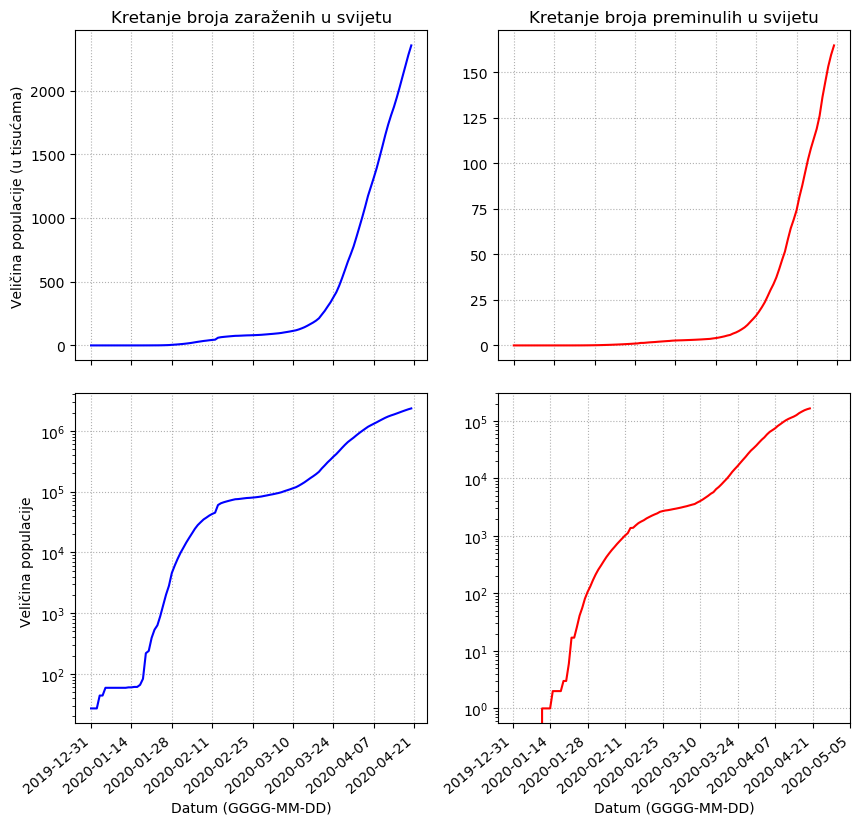

In [55]:
import datetime as dt
from functools import lru_cache
import matplotlib.pyplot as plt
plt.rcParams['figure.max_open_warning'] = 250
%matplotlib agg

@lru_cache()
def izdvoji_državu(država):
    if država == 'World': return izdvoji_državu('China')
    return data[data['Country'] == država]

def ukupno_dnevno_stanje(argument):
    lista=[]
    suma = 0
    for broj in data.groupby(['Date']).sum()[argument]:
        suma += broj
        lista.append(suma)
    return lista

def lista_dnevno_stanje(država, argument):
    if država == 'World': return ukupno_dnevno_stanje(argument)
    lista = []
    i=-1
    for dnevno_stanje in np.array(izdvoji_državu(država)[argument]):
        if i==-1: lista.append(int(dnevno_stanje))
        else: lista.append(int(dnevno_stanje)+lista[i])
        i +=1
    return lista

pridjevi = {'Cases': 'zaraženi', 'Deaths':'preminuli', 0:'Cases', 1:'Deaths'}
skale = {0:'linear', 1:'log'}
boje = {0:'blue', 1:'red'}
jedinica = {0:1000, 1:1, 2:'(u tisućama)', 3: ''}
države = {država:'državi: \n'+ država.replace('_', ' ') for država in data['Country'].drop_duplicates()}
države['World'] = 'svijetu'

def prikaz_kontinuiranog_stanja(država):
    #n = (dt.datetime(2020, 4, 17)-dt.datetime(2019, 12, 31)).days
    #base =dt.datetime(2019, 12, 31)
    dates = np.array(izdvoji_državu(država)['Date'])
    k = 0
    for broj in izdvoji_državu(država)['Cases']: 
        if broj == 0: k += 1
        else: break
    if k > 2: k -= 2
    n = dates[k:].shape[0]//8
    base = dates[k]
    dates2 = np.array([base + np.timedelta64(i*n, 'D') for i in range (0, 10)])
    fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, squeeze=True, figsize=(10, 9), gridspec_kw=dict(hspace=0.1))
    plt.xticks(rotation=40, ha='right')
    for i in range (0, 2):
        for j in range (0, 2):
            ax[i][j].plot(dates[k:], np.array(lista_dnevno_stanje(država, pridjevi[j]))[k:]/jedinica[i], color=boje[j])     
            ax[0][j].set_title('Kretanje broja ' + pridjevi[pridjevi[j]] + 'h u ' + države[država], fontsize='large')
            ax[i][0].set_ylabel('Veličina populacije ' + jedinica[i+2])
            ax[1][j].set_xlabel('Datum (GGGG-MM-DD)', fontsize='medium')
            ax[i][j].set_yscale(skale[i])
            plt.setp( ax[i][j].xaxis.get_majorticklabels(), rotation=40, ha='right')
            ax[i][j].set_xticks(dates2)
            ax[i][j].grid(linestyle = ':')
    return fig

prikaz_kontinuiranog_stanja('World')

Ovako napisanu prethodnu funkciju možemo korsititi i da bismo prikazali podatke u svakoj pojedinoj državi.<br>
Pogledajmo stoga, na primjer, podatke u Italiji (ovdje iz donjih grafova, koji su u logaritamskoj skali, jasnije uočavamo kako se brzina rasta broja oboljelih i preminulih doista smanjuje, dok nam linearna skala to ne predočava toliko jasno):

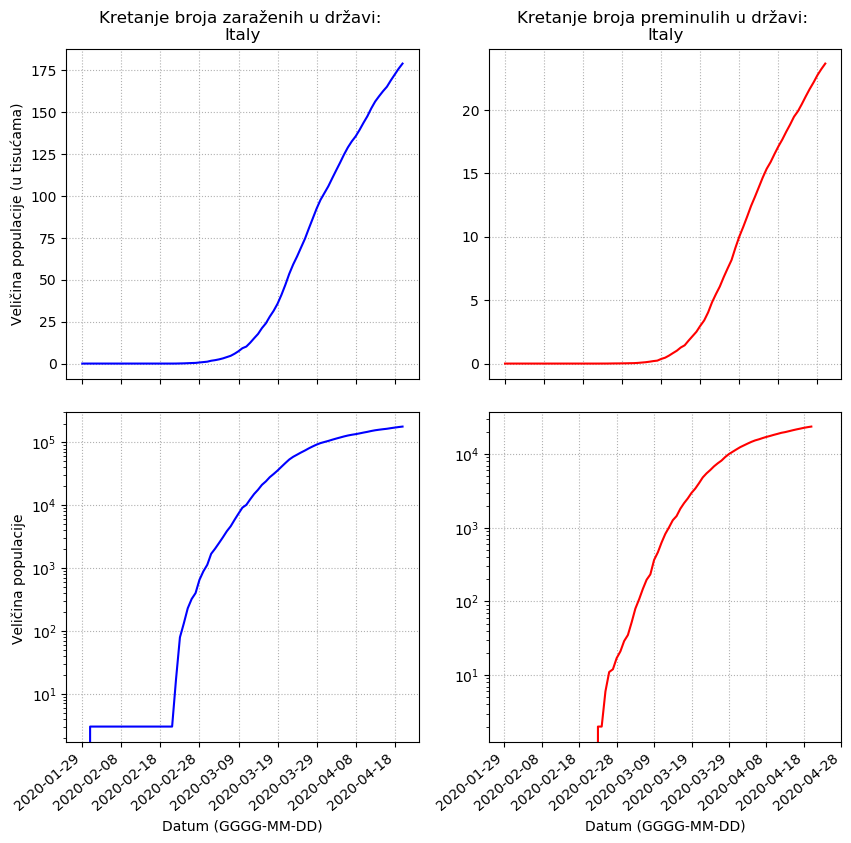

In [3]:
prikaz_kontinuiranog_stanja('Italy')

U medijima svakodnevno nailazimo na <i>usporedbe</i> stanja epidemije u različitim državama. Kao matematičari, mi ipak znamo da ovakve usporedbe imaju smisla jedino kada uspoređujemo udio broja zaraženih u ukupnoj populaciji. Idealno bi također bilo gledati koliki je udio preminulih u ukupnom broju zatvorenih slučajeva; međutim, podatci o broju ozdravljenih po svakoj državi zasebno nam nisu ovako dostupni kao i ostali podatci, pa ćemo također promatrati udio preminulih osoba u ukupnoj populaciji.

In [4]:
def pripremi_podatke(država, argument):
    dates = np.array(izdvoji_državu(država)['Date'])
    n = dates.shape[0]//10
    base = dates[0]
    dates2 = np.array([base + np.timedelta64(i*n, 'D') for i in range (0, 12)])
    return [dates, dates2]
#još jedna pomoćna funkcija za bolju organizaciju podataka

def usporedba(lista):
    brojevi = np.array([izdvoji_državu(država)[izdvoji_državu(država)['Cases']>=0].shape[0] for država in lista])
    broj = brojevi.max()
    k = 0
    for temp in brojevi:
        if broj == temp: break;
        k += 1
    fig, ax = plt.subplots(1, 2, sharex=True, squeeze=True, figsize=(10, 5), gridspec_kw=dict(hspace=0.1))
    for i in range (0, 2):
        datumi = pripremi_podatke(lista[k], pridjevi[i])
        duljina = datumi[0].shape[0]
        for država in lista:
            nova = lista_dnevno_stanje(država, pridjevi[i])[::-1]
            while len(nova) < duljina: nova.append(0)
            ax[i].plot(datumi[0], nova[::-1]/(np.array(izdvoji_državu(država)['Population'])[0]/100), label = država.replace('_', ' '))
            #ax[i][j].plot(dates[k:], np.array(lista_dnevno_stanje(država, pridjevi[j]))[k:]/jedinica[i], color=boje[j])     
            ax[i].set_title('Usporedba kretanja broja ' + pridjevi[pridjevi[i]] + 'h', fontsize='large')
            ax[i].set_xlabel('Datum (GGGG-MM-DD)', fontsize='medium')
            plt.setp( ax[i].xaxis.get_majorticklabels(), rotation=40, ha='right')
            ax[i].set_xticks(datumi[1])
            ax[i].grid(linestyle = ':')
    ax[0].set_ylabel('Udio zaraženih (%)')
    ax[0].legend(loc = 'best')  
    return fig

Stoga prvo pogledajmo usporedbu između Hrvatske i nekih susjeda (Italiju ćemo ostaviti za kasnije). Da se razumijemo, poanta ovog dijela rada nije da epidemiju tretiramo kao 'natjecanje', već da iznesemo točne podatke i ih interpretiramo na ispravan (matematički) način. Stoga je jedina sigurnost koju u ovome grafu možemo vidjeti jest da između broje zaraženih i broja preminulih ne postoji neka jasna veza, jer iako Hrvatska ima najmanji broj preminulih, nema i najmanji broj oboljelih (<i>19. travnja</i>).<br><br>
<b>Važna napomena:</b><br>
Ja mogu interpretirati samo dio ovih podataka, jer se brojevi, to jest tijek epidemije, u državi, Europi i svijetu mijenja iz dana u dan. Podatci koje ja vidim danas (19. travnja) sigurno neće biti isti u trenutku kada Vi ovo čitate. Stoga će sve moje interpretacije podataka biti u kratkim crtama (ili s naznačenim datumom ako je prijeko potrebno) a detaljniju analizu ostavljam Vama. 😊

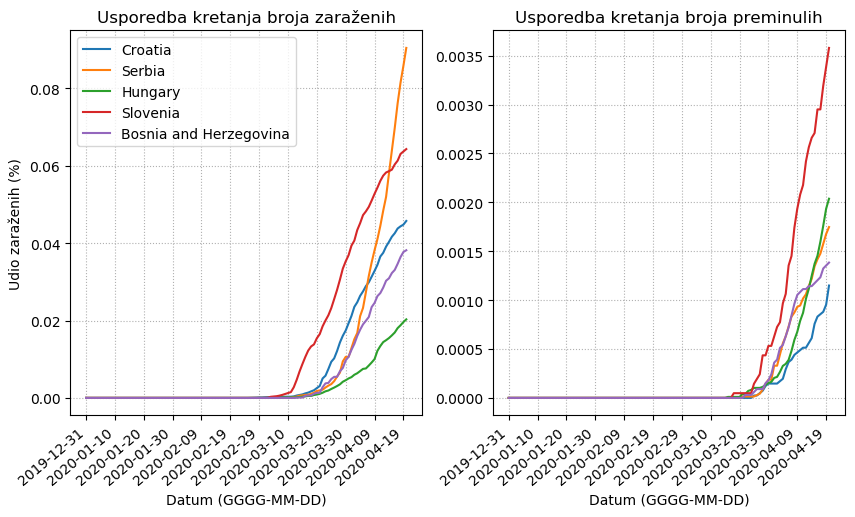

In [5]:
usporedba(['Croatia', 'Serbia', 'Hungary', 'Slovenia', 'Bosnia_and_Herzegovina'])

## Predviđanje daljnjeg razvoja epidemije

Naravno, nas ne zanima isključivo trenutno stanje, već nas zanima možemo li <i>predvidjeti</i> daljnji tijek ove epidemije?<br>
Odgovor: <b>linearna regresija</b>.<br><br>
<i>Slijedi pojašnjenje što je linearna regresija i metoda najmanjih kvadrata i na koji način to ovdje koristimo, nadodat ću tekst naknadno...</i><br><br>
Maločas navedenom metodom možemo procijeniti mogući tijek epidemije (na primjer, za Hrvatsku): <br><br>
Ovdje imamo dva očita problema korištenja linearne regresije:
<lu>
    <li>U stvarnosti je rast rijetko gdje doista eksponencijalan, prije svega jer su nadležne vlasti reagirale relativno pravodobno i učile na dosadašnjim greškama ostalih nacija (jedan relativno dobar primjer je dakako i Hrvatska).</li>
    <li>Na mjestima gdje rast u početku i jest eksponencijalan, obično se on vrlo brzo stavi pod kontrolu pa nam funkcija dobivena ovom metodom više puno i ne koristi (npr. trenutno nam nema smisla na ovaj način proučavati podatke u Kini).</li>
</lu>

In [71]:
import statsmodels.api as sm

def pomoćni_ln(broj):
    if broj == 0: return 0
    else: return float(np.log(broj))

lnn = np.vectorize(pomoćni_ln, otypes=[np.float])

def vrati_procjenu(a, b):
    return lambda x: (np.e**a)*((np.e**b)**x)

def podatci_graf_regresija(država):
    dates = np.array(izdvoji_državu(država)['Date'])
    broj_dana = 0
    while np.array(izdvoji_državu(država)[izdvoji_državu(država)['Date']<=dates[broj_dana]]['Cases']).sum()==0:
        broj_dana += 1
    if broj_dana > 2: broj_dana -= 2
    brojač_dana = [i for i in range(0, dates.shape[0]-broj_dana)]
    brojač_dana2 = sm.add_constant(brojač_dana)
    zaraza = lnn(np.array(lista_dnevno_stanje(država, 'Cases'))[broj_dana:])
    model = sm.OLS(zaraza, brojač_dana2)
    rez = model.fit()
    print(rez.summary())
    funkcija = vrati_procjenu(rez.params[0], rez.params[1])
    n = dates[broj_dana:].shape[0]//10
    base = dates[broj_dana]
    dates2 = np.array([base + np.timedelta64(i*n, 'D') for i in range (0, 12)])
    #također ne želimo da nam se prikaže apsolutno svaki datum jer je to nepregledno
    fig, ax = plt.subplots()
    ax.plot(dates[broj_dana:], lista_dnevno_stanje(država, 'Cases')[broj_dana:], alpha=0.65, lw=2, c='g', label='Pravi brojevi')
    ax.plot(dates[broj_dana:], np.vectorize(funkcija)(brojač_dana), alpha=0.65, c='c', lw=2, label='Procjena')
    plt.xticks(rotation=40, ha='right')
    for spine in ('top', 'right'):
        ax.spines[spine].set_visible(False)
    ax.set_xticks(dates2)
    ax.set_facecolor('#efefef')
    ax.set_title('Stvarni brojevi i dobiveni pomoću OLS u državi: ' + država.replace('_', ' '))
    ax.set_ylabel('Broj zaraženih')
    ax.set_xlabel('Datum (GGGG-MM-DD)')
    ax.legend(loc = 'best')
    ax.grid(b=True, which='major', c='#fdfdfd', lw=2, ls='-')
    return [fig, funkcija]

Primjer kada nam linearna regresija i može reći kako se podatci mogu dalje kretati jest SAD, jer je rast ondje i dalje eksponencijalan:

In [72]:
podatci_SAD = podatci_graf_regresija('Russia')
funkcija_SAD = podatci_SAD[1]

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     772.9
Date:                Mon, 20 Apr 2020   Prob (F-statistic):           7.21e-43
Time:                        22:35:41   Log-Likelihood:                -124.41
No. Observations:                  82   AIC:                             252.8
Df Residuals:                      80   BIC:                             257.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.7980      0.244     -7.355      0.0

<i>Slijedi interpretacija dobivenih podataka...</i><br><br>
Pogledajmo i grafički prikaz stvarnih podataka i dobivenih ovom metodom:

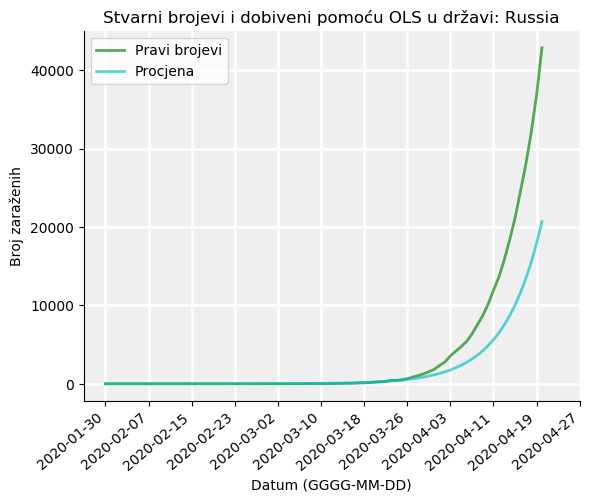

In [73]:
podatci_SAD[0]

Sad možemo i procijeniti mogući broj zaraženih na određeni dan; na primjer, broj zaraženih dana 20. travnja 2020. mogao bi biti $1826126$.

In [9]:
int(round(funkcija_SAD((dt.datetime(2020, 4, 20)-dt.datetime(2020, 1, 19)).days)))

101765

Kao što sam naveo prije, u Hrvatskoj nam ova metoda ne pruža mnogo korisnih podataka jer rast nije eksponencijalan. Jasno vidimo da stoga ovaj rezultat nije egzaktan, pa niti daljnje procjene ne možemo prihvatiti s nekom pouzdanošću.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     689.1
Date:                Mon, 20 Apr 2020   Prob (F-statistic):           1.14e-31
Time:                        21:24:01   Log-Likelihood:                -52.416
No. Observations:                  54   AIC:                             108.8
Df Residuals:                      52   BIC:                             112.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9642      0.175      5.518      0.0

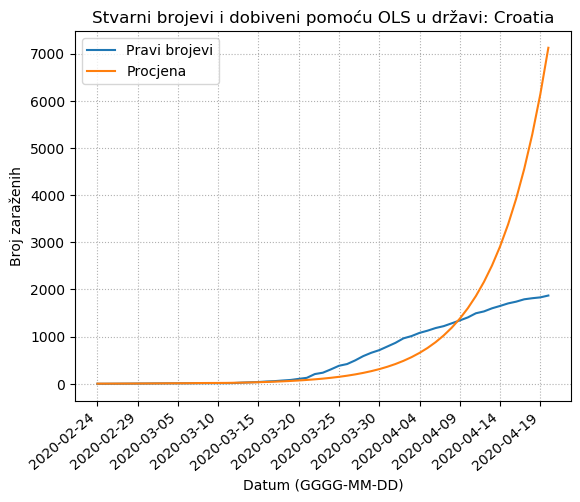

In [10]:
podatci_RH = podatci_graf_regresija('Croatia')
funkcija_RH = podatci_RH[1]
podatci_RH[0]

Za primjer, ova nam procjena kaže da bismo za šest dana, 20. travnja 2020. trebali imati čak $15427$ zaraženih, što je vrlo malo vjerojatan scenarij:

In [11]:
int(round(funkcija_RH((dt.datetime(2020, 4, 20)-dt.datetime(2020, 2, 27)).days)))

7124

## Epidemiološki modeli

Ideja za nastavak rada bi bila proučiti relevantne epidemiološke modele za infektivne bolesti.<br>
Modeli se temelje na pretpostavci da imamo tri grupe ljudi:<br><br>
<lu>
    <li>oni koji su podložni bolesti (<i>susceptible</i> - S)</li>
    <li>širitelji zaraze (<i>infectious</i> - I)</li>
    <li>oporavljeni (<i>recovered</i> - R)</li>
</lu><br><br>
Ovisno o mogućnosti prijelaza imamo dva osnovna modela (koja bismo htjeli promatrati):<br><br>
<lu>
    <li> SIR - mogući su prijelazi iz podložnog bolesti u širitelj zaraze, te iz širitelja zaraze u oporavljenog, ali je glavna pretpostavka da se ljudi koji se oporave više ne mogu zaraziti</li>
    <li> SIRS - za razliku od SIR modela, ovdje se pretpostavlja da ljudi nakon što se oporave mogu opet biti podložni zarazi (nakon izvjesnog vremena)</li>
</lu><br><br>

<i>Konkretne informacije i oznake ovih dvaju modela</i>

<br><br>
U sljedećem grafu imamo vizualizaciju SIR i SIRS modela u ovisnosti o parametrima. Uočimo da je za gama = 0 riječ o SIR modelu, inače je riječ o SIRS modelu.

In [75]:
from scipy.integrate import odeint
import ipywidgets as widgets

N = 1000
I0, R0 = 1, 0
S0 = N - I0 - R0
beta, gama= 0.2, 1./10
dani = np.linspace(0, 150, 150)

def deriv(y, t, N, beta, gama, sigma):
    S, I, R = y
    dSdt = -beta * S * I / N + sigma * R
    dIdt = beta * S * I / N - gama * I
    dRdt = gama * I - sigma * R
    return dSdt, dIdt, dRdt

def pomoc(sigma):
    y0 = S0, I0, R0
    rez = odeint(deriv, y0, dani, args=(N, beta, gama, sigma))
    S, I, R = rez.T

    fig, ax = plt.subplots()
    ax.plot(dani, S/1000, 'b', alpha=0.65, lw=2, label='Susceptible')
    ax.plot(dani, I/1000, 'r', alpha=0.65, lw=2, label='Infected')
    ax.plot(dani, R/1000, 'g', alpha=0.65, lw=2, label='Recovered with immunity')
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Number (1000s)')
    ax.set_ylim(0,1.2)
    ax.set_facecolor('#efefef')
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='#fdfdfd', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right'):
        ax.spines[spine].set_visible(False)
    return fig

k=widgets.interact(pomoc, sigma = widgets.FloatSlider(value=0, min=0, max=0.2, step=0.005))

interactive(children=(FloatSlider(value=0.0, description='sigma', max=0.2, step=0.005), Output()), _dom_classe…

Da bismo dobili stvarnu sliku ovih dvaju modela, prikazat ćemo stvarne podatke na području Hrvatske. Potrebne podatke sam prikupio i pohranio u datoteku korona_RH.csv.<br><br>
Budući da brzinu prijelaza iz <i>podložnih zarazi</i> u <i>zaraženi</i> i iz <i>zaraženi</i> u <i>oporavljeni</i> već imamo, ovdje ćemo prikazati podatke u ovisnosti o brzini prijelaza iz <i>oporavljeni</i> u <i>podložni zarazi</i>. Kada je taj parametar jednak -1, tada pretpostavljamo da svi koji su ozdravljeni imaju imunitet (sukladno SIR modelu, dakako). Inače su naši podaci malo modificirani, jer pretpostavljamo da se nakon nekog vremena izgubi imunitet.<br><br>
Napomenimo samo da biram podatke prikazati ovako "razdvojeno" jer je riječ o vrlo malim pomacima, to jest mali udio populacije je zaražen. Stoga, da prikazujem sve podatke na istom grafu, imali bismo dvije naizgled ravne crte iz kojih ništa ne bismo mogli zaključiti.

In [120]:
import copy

data_RH = pd.read_csv('korona_rh.csv')
data_RH['Date'] = pd.to_datetime(dict(year=data_RH['Year'], month=data_RH['Month'], day=data_RH['Day']))
del data_RH['Year'], data_RH['Month'], data_RH['Day']

N=list(izdvoji_državu('Croatia')['Population'])[0]

def crtaj_RH_SIRS(trajanje_imuniteta):
    S=[]
    I=[]
    R=[]
    for podatak in data_RH['Cases']:
        S.append(N-podatak)
    I = data_RH['Cases'] - data_RH['Recovered'] - data_RH['Deaths']
    R = copy.deepcopy(data_RH['Recovered'])
    if trajanje_imuniteta != -1:
        for i in range(int(trajanje_imuniteta), len(S)):
            S[i] += R[i-trajanje_imuniteta]
            R[i] -= R[i-trajanje_imuniteta]
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(6, 5), gridspec_kw=dict(hspace=0.2))
    ax[0].plot(data_RH['Date'], S, c='b', label='Podložni zarazi')
    ax[1].plot(data_RH['Date'], I, c='r', label='Zaraženi')
    ax[1].plot(data_RH['Date'], R, c='g', label='Oporavljeni')
    plt.xticks(rotation=40, ha='right')
    for spine in ('top', 'right'):
        ax[0].spines[spine].set_visible(False)
        ax[1].spines[spine].set_visible(False)
    ax[0].spines['bottom'].set_visible(False)
    ax[0].tick_params(axis='x', color='w')
    for i in range(0, 2):
        ax[i].grid(b=True, which='major', c='#fdfdfd', lw=2, ls='-')
        ax[i].set_facecolor('#efefef')
        legend = ax[i].legend(loc='best')
        legend.get_frame().set_alpha(0.5)
    return fig

k=widgets.interact(crtaj_RH_SIRS, trajanje_imuniteta = widgets.FloatSlider(value=-1, min=-1, max=14, step=1))

interactive(children=(FloatSlider(value=-1.0, description='trajanje_imuniteta', max=14.0, min=-1.0, step=1.0),…

<b>NAPOMENE I IDEJE</b>:<br><br>
<lu>
    <li>Paziti da ovo doista bude priča, a ne samo crtanje lijepih grafova u raznim bojama!</li>
    <li>Sve dosadašnje sekcije nadopuniti konkretnim tekstom i pojašnjenjima što se zapravo događa i što radimo.</li>
    <li>Bilo bi zgodno prilagoditi dosadašnje funkcije tako da nemamo razdvojeni prikaz broja zaraženih i preminulih nego da ta dva grafa budu <i>side-by-side</i>.</li>
    <li>Mogućnost ubacivanja histograma koji bi prikazivao broj novozaraženih po danima.</li>
    <li>Možda kakav 3D graf? Ili animacija? </li>
    <li>Poseban fokus staviti na Hrvatsku i njezine brojke. Prikupiti dodatne podatke o kretanju broja oporavljenih (tj. stranice koronavirus.hr) i prikazati ih.</li>
    <li>Nadalje razviti sekciju o epidemiološkim modelima.</li>
    <li>Urediti kod: prilagoditi imena varijabli (da nemamo bilingvalne nazive), riješiti redundancije u kodu (<u>a ima ih</u>) uvođenjem još nekih pomoćnih funkcija. </li>
</lu>